<a href="https://colab.research.google.com/github/sheikmohdimran/Experiments_2020/blob/master/Vision/Drift_Detection_FastAI_Alibi_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alibi_detect -q
!pip install fastai2 -q 

     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 11.0MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 184kB 2.8MB/s 


##Train MNIST

In [2]:
from fastai2.vision.all import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [73]:
path = untar_data(URLs.MNIST)

'path = untar_data(URLs.PETS)\nfiles = get_image_files(path/"images")\ndef label_func(f): return f[0].isupper()'

In [75]:
dls = ImageDataLoaders.from_folder(path, train='training',valid_pct=0.2)
learn = cnn_learner(dls, resnet18, bs=64, metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.326660,0.169032,0.947643,01:04
1,0.128025,0.078880,0.976929,01:03
2,0.100732,0.072237,0.978214,01:03


In [76]:
learn.save('resnet-18-mnist')
learn.load('resnet-18-mnist');

"learn.save('resnet-34-pets')\nlearn.load('resnet-34-pets');"

In [134]:
def print_accuracy(learner,folder,dls):
  test_files=L([f for f in Path(folder).glob('**/*.png')])
  test_dl = learner.dls.test_dl(test_files, with_label=False)
  preds,_ = learner.get_preds(dl=test_dl)  
  pred_vals=[]
  for index, item in enumerate(preds): 
    prediction = dls.categorize.decode(np.argmax(item)).upper() 
    pred_vals.append([test_dl.items[index].name,prediction])

  df_pred = pd.DataFrame(pred_vals)
  df_pred.columns = ['file', 'pred']
  test_org=[[f.name, str(f.parents[0]).split('/')[-1]] for f in Path(path/'testing').glob('**/*.png')]
  df_test = pd.DataFrame(test_org)
  df_test.columns = ['file', 'label']
  df_final=pd.merge(df_pred[['file','pred']],df_test, on='file')
  return accuracy_score(df_final['label'], df_final['pred'])

##Generate noisy dataset

In [135]:
! rm -rf GaussNoise MotionBlur my_path

In [136]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import albumentations as A
import random

###Gauss Noise

In [80]:
!cp -R /root/.fastai/data/mnist_png/testing .
!mv testing GaussNoise

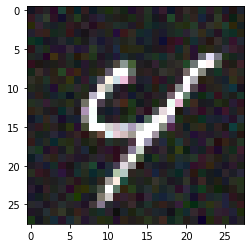

In [81]:
GaussNoise_files=[f for f in Path('./GaussNoise').glob('**/*.png')]

img = cv2.imread(str(GaussNoise_files[0]))
light = A.Compose([A.GaussNoise(var_limit=(100.0, 500.0))], p=1)
plt.imshow(cv2.cvtColor(light(image=img)['image'], cv2.COLOR_BGR2RGB))

In [82]:
for index, item in enumerate(tqdm(GaussNoise_files)): 
  light = A.Compose([A.GaussNoise(var_limit=(100.0, 500.0))], p=1)
  img = cv2.imread(str(item))
  img1 = cv2.cvtColor(light(image=img)['image'], cv2.COLOR_BGR2RGB)
  cv2.imwrite(str(item), img1) 

100%|██████████| 10000/10000 [00:04<00:00, 2179.80it/s]


###Motion Blur

In [83]:
!cp -R /root/.fastai/data/mnist_png/testing .
!mv testing MotionBlur

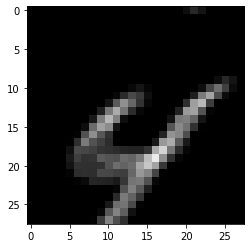

In [84]:
MotionBlur_files=[f for f in Path('./MotionBlur').glob('**/*.png')]

img = cv2.imread(str(MotionBlur_files[0]))
light = A.Compose([A.MotionBlur(blur_limit=15, p=1)])
plt.imshow(cv2.cvtColor(light(image=img)['image'], cv2.COLOR_BGR2RGB))

In [85]:
for index, item in enumerate(tqdm(MotionBlur_files)): 
  light = A.Compose([A.MotionBlur(blur_limit=15, p=1)])
  img = cv2.imread(str(item))
  img1 = cv2.cvtColor(light(image=img)['image'], cv2.COLOR_BGR2RGB)
  cv2.imwrite(str(item), img1) 

100%|██████████| 10000/10000 [00:03<00:00, 2854.91it/s]


Inference Accuracy

In [137]:
print_accuracy(learn,path/'testing',dls)

0.9841

In [87]:
print_accuracy(learn,'./GaussNoise',dls)

0.7127

In [88]:
print_accuracy(learn,'./MotionBlur',dls)

0.6079

## Alibi Detect

In [89]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape

from alibi_detect.cd import KSDrift
from alibi_detect.cd.preprocess import uae, hidden_output
from alibi_detect.utils.saving import save_detector, load_detector

In [102]:
train_list=[f for f in Path(path/'training').glob('**/*.png')]
train_1 = np.array([np.array(cv2.imread(str(fname))) for fname in train_list])
train_1.shape

(60000, 28, 28, 3)

In [117]:
tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(28, 28, 3)),
      Conv2D(14, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(7, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

# initialise drift detector
p_val = .05
cd = KSDrift(
    p_val=p_val,        # p-value for K-S test
    X_ref=train_1,       # execute against original training set
    preprocess_fn=uae,  # UAE for dimensionality reduction
    preprocess_kwargs={'encoder_net': encoder_net, 'batch_size': 128},
    alternative='two-sided'  # other options: 'less', 'greater'
)

# we can also save/load an initialised detector
filepath = 'uae_dest'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

In [123]:
valid_list=list(learn.dls.valid.items)
valid_1 = np.array([np.array(cv2.imread(str(fname))) for fname in valid_list])

In [124]:
# Check for Drift in Validation data, compared to Training data
preds_h0 = cd.predict(valid_1, return_p_val=True)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))

Drift? No!


In [125]:
print(preds_h0['data']['p_val'])

[0.27910402 0.03258128 0.6825555  0.01903064 0.98591757 0.7929366
 0.9084443  0.74983996 0.9535649  0.26195264 0.30855486 0.99967873
 0.7202761  0.9988217  0.67743534 0.8349646  0.89276665 0.9692008
 0.14980586 0.13842063 0.5921058  0.9013396  0.07528443 0.58703446
 0.3867598  0.4579381  0.69065005 0.5853463  0.8446657  0.98870426
 0.17976397 0.18830748]


In [126]:
gauss_list=[f for f in Path('./GaussNoise').glob('**/*.png')]
gauss_1 = np.array([np.array(cv2.imread(str(fname))) for fname in gauss_list])

In [128]:
# Check for Drift in GaussNoise data, compared to Training data
preds_h0 = cd.predict(gauss_1, return_p_val=True)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))

Drift? Yes!


In [129]:
print(preds_h0['data']['p_val'])

[1.2141666e-21 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.8513903e-09
 8.4001528e-11 0.0000000e+00 0.0000000e+00 3.1019714e-15 0.0000000e+00
 2.1176522e-17 1.3978313e-10 2.3357163e-23 0.0000000e+00 0.0000000e+00
 4.9525810e-31 1.5375574e-38 0.0000000e+00 0.0000000e+00 0.0000000e+00
 2.4932867e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6904931e-43
 1.0600891e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.3936231e-04
 3.6796086e-02 1.2282579e-12]


In [130]:
motionblur_list=[f for f in Path('./GaussNoise').glob('**/*.png')]
motionblur_1 = np.array([np.array(cv2.imread(str(fname))) for fname in motionblur_list])

In [131]:
# Check for Drift in MotionBlur data, compared to Training data
preds_h0 = cd.predict(motionblur_1, return_p_val=True)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))

Drift? Yes!
